# Synthetic data test
This notebook was used to perform tests for the synthetic data generation.  
Steps:
  1. Add neurons as gaussians (foreground)
  2. Deform image (warping, different shapes, translation, etc.)
     * Sample from warped neurons to get pixelated aspect
  3. Add background noise

In [1]:
%matplotlib inline

import os, time, pickle
import warnings
import math
import ipywidgets as widgets
from ipywidgets import interact

import numpy as np
import matplotlib.pyplot as plt
from skimage import io, measure, draw, exposure, filters
from skimage import morphology as morph
from scipy import stats, special
from scipy.stats import multivariate_normal, entropy, norm
from scipy.special import gamma, digamma, polygamma
from imgaug import augmenters as iaa

from utils_common.image import imread_to_float, overlay_mask, to_npint
from utils_common.processing import flood_fill

%load_ext autoreload
%autoreload 2

In [2]:
shape = (192, 256)

# True data statistics
  1. Compute array of pixels intensity based on background/foreground segmentation
  2. Compute intensity statistics about ROIs

In [5]:
data_dir = "/data/talabot/dataset_cv-annotated/"

bins = np.linspace(0, 1, 257)
pixel_bkg = np.zeros(bins.size - 1, dtype=np.uint32)
pixel_fg = np.zeros(bins.size - 1, dtype=np.uint32)
roi_max = np.zeros(bins.size - 1, dtype=np.uint32)
roi_ave = np.zeros(bins.size - 1, dtype=np.uint32)
roi_med = np.zeros(bins.size - 1, dtype=np.uint32)
roi_q75 = np.zeros(bins.size - 1, dtype=np.uint32)
bkg_mean = np.zeros(bins.size - 1, dtype=np.uint32)

start = time.time()
for set in ["train", "validation", "test", "train_fail", "validation_fail", "test_fail"]:
    exp_list = sorted(os.listdir(os.path.join(data_dir, set)))
    for i, exp in enumerate(exp_list):
        if (i + 1) % 5 == 0:
            print("Folder %d/%d" % (i + 1, len(exp_list)))

        stack = imread_to_float(os.path.join(data_dir, set, exp, "RGB.tif"))[...,0]
        seg = io.imread(os.path.join(data_dir, set, exp, "seg_ROI.tif")).astype(np.bool)

        for n in range(len(stack)):
            bkg = stack[n][np.logical_not(seg[n])]
            if bkg.size != 0:
                bkg_mean[int(np.rint(np.mean(bkg) * 255))] += 1
        pixel_bkg += plt.hist(stack[np.logical_not(seg)].ravel(), bins=bins)[0].astype(pixel_bkg.dtype)
        pixel_fg += plt.hist(stack[seg].ravel(), bins=bins)[0].astype(pixel_fg.dtype)
        plt.close()

        # ROI stats
        for k in range(seg.shape[0]):
            labels = measure.label(seg[k])
            for region in measure.regionprops(labels):
                roi_max[int(np.max(stack[k][labels == region.label]) * 255)] += 1
                roi_ave[int(np.mean(stack[k][labels == region.label]) * 255)] += 1
                roi_med[int(np.median(stack[k][labels == region.label]) * 255)] += 1
                roi_q75[int(np.percentile(stack[k][labels == region.label], 75) * 255)] += 1

print("Took %d s." % (time.time() - start))
print("%d background pixels" % pixel_bkg.sum())
print("%d foreground pixels" % pixel_fg.sum())

print("ROI (averaged through %d ROIs):" % np.sum(roi_max))
print("  - max =", np.sum(roi_max * np.linspace(0, 1, 256) / roi_max.sum()))
print("  - ave =", np.sum(roi_ave * np.linspace(0, 1, 256) / roi_ave.sum()))
print("  - med =", np.sum(roi_med * np.linspace(0, 1, 256) / roi_med.sum()))
print("  - q75 =", np.sum(roi_q75 * np.linspace(0, 1, 256) / roi_q75.sum()))

# # Save results to avoid computing again
# date = time.strftime("%y%m%d")
# print("Save at stats_%s.pkl" % date)
# with open("stats_%s.pkl" % date, "wb") as f:
#     pickle.dump((pixel_bkg, pixel_fg, roi_max, roi_ave, roi_med, roi_q75), f)

Folder 5/30
Folder 10/30
Folder 15/30
Folder 20/30
Folder 25/30
Folder 30/30
Folder 5/10
Folder 10/10
Folder 5/8
Folder 5/48
Folder 10/48
Folder 15/48
Folder 20/48
Folder 25/48
Folder 30/48
Folder 35/48
Folder 40/48
Folder 45/48
Folder 5/13
Folder 10/13
Folder 5/19
Folder 10/19
Folder 15/19
Took 421 s.
3836446891 background pixels
53933909 foreground pixels
ROI (averaged through 424474 ROIs):
  - max = 0.6120638904694686
  - ave = 0.19407023428396314
  - med = 0.16572422228313574
  - q75 = 0.2779766552135067


In [9]:
# with open("stats_181121.pkl", "rb") as f:
#     pixel_bkg, pixel_fg, roi_max, roi_ave, roi_med, roi_q75 = pickle.load(f)
        
# Following are probability for bkg/fg pixels, simply hist/hist.sum()
p_bkg = pixel_bkg / pixel_bkg.sum()
p_fg = pixel_fg / pixel_fg.sum()

# Following are for the ROI region only
p_roi_max = roi_max / roi_max.sum()
p_roi_ave = roi_ave / roi_ave.sum()
p_roi_med = roi_med / roi_med.sum()
p_roi_q75 = roi_q75 / roi_q75.sum()

# Some pre-computed statistics
print(pixel_bkg.sum(), "background pixels")
print(pixel_fg.sum(), "foreground pixels")
print("ROI (averaged through %d ROIs):" % roi_max.sum())
print("  - max =", np.sum(roi_max * np.linspace(0, 1, 256) / roi_max.sum()))
print("  - ave =", np.sum(roi_ave * np.linspace(0, 1, 256) / roi_ave.sum()))
print("  - med =", np.sum(roi_med * np.linspace(0, 1, 256) / roi_med.sum()))
print("  - q75 =", np.sum(roi_q75 * np.linspace(0, 1, 256) / roi_q75.sum()))

3836446891 background pixels
53933909 foreground pixels
ROI (averaged through 424474 ROIs):
  - max = 0.6120638904694686
  - ave = 0.19407023428396314
  - med = 0.16572422228313574
  - q75 = 0.2779766552135067


Display them (restructure them from 256 bins to 20 for better visualization).

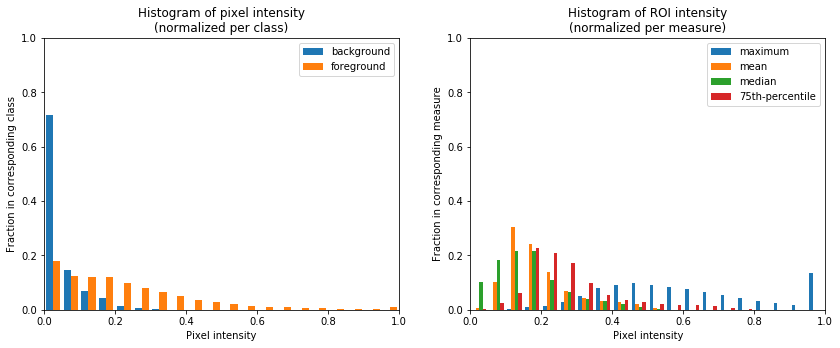

In [10]:
# Restructure the bins for plotting purposes
increment = 0.05
new_bins = np.arange(0, 1 + increment, increment)
increment_to_int = int(np.rint(255 / (new_bins.size - 1)))
new_pixel_bkg = np.zeros(new_bins.size - 1, dtype=np.uint32)
new_pixel_fg = np.zeros(new_bins.size - 1, dtype=np.uint32)
new_roi_max = np.zeros(new_bins.size - 1, dtype=np.uint32)
new_roi_ave = np.zeros(new_bins.size - 1, dtype=np.uint32)
new_roi_med = np.zeros(new_bins.size - 1, dtype=np.uint32)
new_roi_q75 = np.zeros(new_bins.size - 1, dtype=np.uint32)
for i in range(new_bins.size - 1):
    new_pixel_bkg[i] = pixel_bkg[i * increment_to_int: (i + 1) * increment_to_int].sum()
    new_pixel_fg[i] = pixel_fg[i * increment_to_int: (i + 1) * increment_to_int].sum()
    new_roi_max[i] = roi_max[i * increment_to_int: (i + 1) * increment_to_int].sum()
    new_roi_ave[i] = roi_ave[i * increment_to_int: (i + 1) * increment_to_int].sum()
    new_roi_med[i] = roi_med[i * increment_to_int: (i + 1) * increment_to_int].sum()
    new_roi_q75[i] = roi_q75[i * increment_to_int: (i + 1) * increment_to_int].sum()

# Bars' parameters
ratio_bar = 0.80 # ratio of bar_width/interval_width
width = increment * ratio_bar / 2
offset_left = (increment - width) / 2
offset_right = (increment + width) / 2

plt.figure(figsize=(14,5))
plt.subplot(121)
plt.bar(new_bins[:-1] + offset_left, new_pixel_bkg / new_pixel_bkg.sum(), width=width)
plt.bar(new_bins[:-1] + offset_right, new_pixel_fg / new_pixel_fg.sum(), width=width)
plt.xlim(0, 1); plt.ylim(0, 1)
plt.title("Histogram of pixel intensity\n(normalized per class)")
plt.xlabel("Pixel intensity")
plt.ylabel("Fraction in corresponding class")
plt.legend(["background", "foreground"])

plt.subplot(122)
plt.bar(new_bins[:-1] + offset_left - width/4, new_roi_max / new_roi_max.sum(), width=width/2)
plt.bar(new_bins[:-1] + offset_left + width/4, new_roi_ave / new_roi_ave.sum(), width=width/2)
plt.bar(new_bins[:-1] + offset_right - width/4, new_roi_med / new_roi_med.sum(), width=width/2)
plt.bar(new_bins[:-1] + offset_right + width/4, new_roi_q75 / new_roi_q75.sum(), width=width/2)
plt.xlim(0, 1); plt.ylim(0, 1)
plt.title("Histogram of ROI intensity\n(normalized per measure)")
plt.xlabel("Pixel intensity")
plt.ylabel("Fraction in corresponding measure")
plt.legend(["maximum", "mean", "median", "75th-percentile"])
plt.show()

# 1. Neurons generation

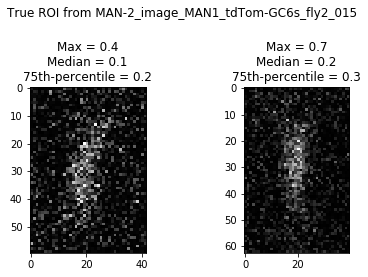

In [14]:
# Load a random true example
rand_exp = np.random.choice(os.listdir("/data/talabot/dataset/train/"))
neuron_ex = imread_to_float(os.path.join("/data/talabot/dataset/train/", rand_exp, "RGB.tif"))[..., 0]
gt_ex = imread_to_float(os.path.join("/data/talabot/dataset/train/", rand_exp, "seg_ROI.tif"))
rand_n = np.random.randint(neuron_ex.shape[0])

labels = measure.label(gt_ex[rand_n])
plt.figure()
plt.suptitle("True ROI from %s" % rand_exp)
n = 0
for region in measure.regionprops(labels):
    n += 1
    min_r, min_c, max_r, max_c = region.bbox
    min_r = max(0, min_r - 15)
    max_r = min(gt_ex[rand_n].shape[0], max_r + 15)
    min_c = max(0, min_c - 15)
    max_c = min(gt_ex[rand_n].shape[1], max_c + 15)
    plt.subplot(1,labels.max(),n)
    plt.imshow(neuron_ex[rand_n, min_r:max_r, min_c:max_c], cmap='gray')
    plt.title("Max = %.1f\nMedian = %.1f\n75th-percentile = %.1f" % \
              (np.max(neuron_ex[rand_n][labels == region.label]),
               np.median(neuron_ex[rand_n][labels == region.label]),
               np.percentile(neuron_ex[rand_n][labels == region.label], 75)))
plt.tight_layout(rect=[0, 0.03, 1, 0.90])
plt.show()

Create multiple neurons at once (as gaussian weights).

Frequency of intensity 1.0: 0.12608310520785726

Mean and std: 0.5560949652737859 0.1795409180323788
Random sampling: 0.6480856086707412


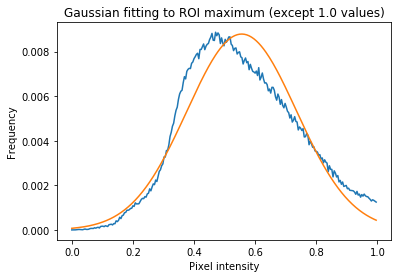

In [16]:
# Maximum ROI fitting with Gaussian
print("Frequency of intensity 1.0:", p_roi_max[-1])

tmp_p_roi_max = p_roi_max.copy()[:-1]
tmp_p_roi_max /= tmp_p_roi_max.sum() # rescaling
loc = np.sum(tmp_p_roi_max * np.arange(255) / 255)
scale = np.sqrt(np.sum(tmp_p_roi_max * (np.arange(255) / 255 - loc) ** 2))
print("\nMean and std:", loc, scale)
print("Random sampling:", np.clip(np.random.normal(loc=loc, scale=scale), 0, 1))
    
plt.plot(np.arange(255) / 255, tmp_p_roi_max)
gauss = norm.pdf(np.arange(255) / 255, loc=loc, scale=scale)
plt.plot(np.arange(255) / 255, gauss / gauss.sum())
plt.xlabel("Pixel intensity")
plt.ylabel("Frequency")
plt.title("Gaussian fitting to ROI maximum (except 1.0 values)")
plt.show()

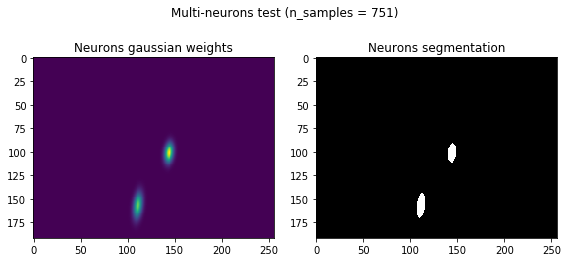

In [17]:
ellipse_size = 1.5 # factor for the ground truth ellipse (normalized by std)
n_neurons = 2
n_samples = int(np.random.normal(loc=1000, scale=200) + 0.5)

bkg = np.zeros(shape, dtype=np.float32)

means = np.zeros((n_neurons, 2))
covs = np.zeros((n_neurons, 2, 2))
neurons_segs = np.zeros((n_neurons,) + shape, dtype=np.bool)
contours = np.zeros((n_neurons,) + shape, dtype=np.bool)
for i in range(n_neurons):
    # Create neuron infinitly until in image and no overlap with another
    # TODO: change this to something that cannot loop to infinity
    while True:
        # Mean and covariance matrix of gaussian (manually tuned)
        # Note that x and y axes are col and row (so, inversed!)
        means[i] = np.array([np.random.randint(shape[1]), np.random.randint(shape[0])])
        scale_x = shape[1] / 50
        scale_y = shape[0] / 50
        cross_corr = np.random.randint(-2, 2) * min(scale_x, scale_y)
        covs[i] = np.array([
            [np.random.randint(1, 3) * scale_x, cross_corr],
            [cross_corr, np.random.randint(10, 30) * scale_y]
        ])

        # Bounding ellipses
        val, vec = np.linalg.eig(covs[i])
        rotation = math.atan2(vec[0, np.argmax(val)], vec[1, np.argmax(val)])
        rr, cc = draw.ellipse(means[i,1], means[i,0], 
                              ellipse_size * np.sqrt(val[1]), ellipse_size * np.sqrt(val[0]),
                              rotation=rotation)
        # Check if outside the image
        if (rr < 0).any() or (rr >= shape[0]).any() or (cc < 0).any() or (cc >= shape[1]).any():
            continue
        # Check if overlapping with any existing neuron
        elif (neurons_segs[:, rr, cc] == True).any():
            continue
        else:
            break
    neurons_segs[i, rr, cc] = True
    tmp_contour = np.concatenate(measure.find_contours(neurons_segs[i], 0)).astype(np.int)
    contours[i, tmp_contour[:,0], tmp_contour[:,1]] = True
    
# Reduce segmentations
neurons_segs = neurons_segs.sum(axis=0)

# Create gaussian weights images
rows, cols = np.arange(shape[0]), np.arange(shape[1])
grid = np.zeros(shape + (2,))
grid[:,:,0], grid[:,:,1] = np.meshgrid(cols, rows) # note the order!
neurons_gaussians = np.zeros((n_neurons,) + shape)
for i in range(n_neurons):
    neurons_gaussians[i,:,:] = multivariate_normal.pdf(grid, means[i], covs[i])
    neurons_gaussians[i,:,:] /= neurons_gaussians[i,:,:].sum()


plt.figure(figsize=(8, 4))
plt.suptitle("Multi-neurons test (n_samples = %d)" % (n_samples))
plt.subplot(121)
plt.imshow(neurons_gaussians.max(0))
plt.title("Neurons gaussian weights")
plt.subplot(122)
plt.imshow(neurons_segs, cmap='gray')
plt.title("Neurons segmentation")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 2. Deformations

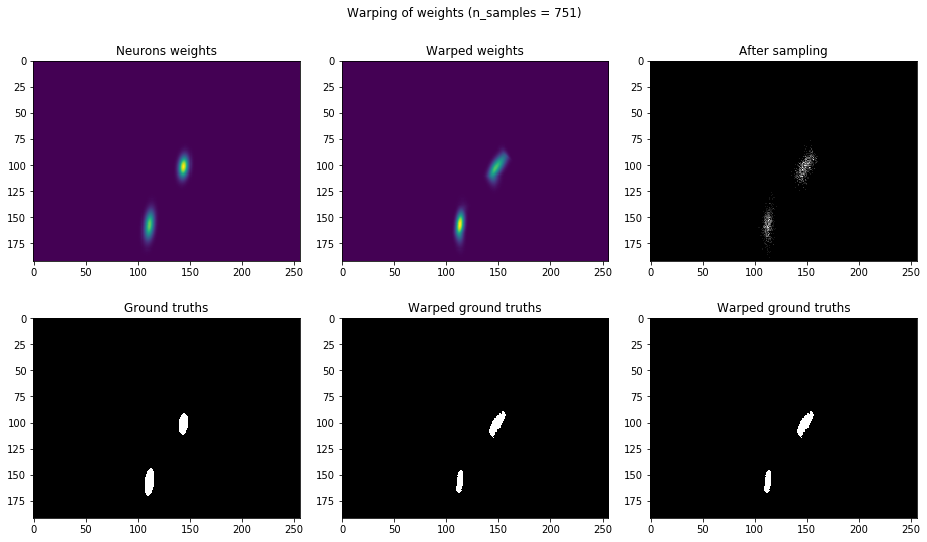

In [18]:
grid_size = 8

# Define warping sequence
wrpseq = iaa.Sequential([
    iaa.PiecewiseAffine(scale=0.025, nb_rows=grid_size, nb_cols=grid_size)
])
seq_det = wrpseq.to_deterministic()

# Warp the gaussian weighting
wrp_gaussians = np.zeros_like(neurons_gaussians)
for i in range(n_neurons):
    wrp_gaussians[i] = seq_det.augment_image(neurons_gaussians[i])
    wrp_gaussians[i] /= wrp_gaussians[i].sum()

# Random maximum sampling 
max_neurons = []
for i in range(n_neurons):
    # First, check if 1.0, then gaussian sampling
    if np.random.rand() < p_roi_max[-1]:
        max_neurons.append(1.0)
    else:
        tmp_p_roi_max = p_roi_max.copy()[:-1]
        tmp_p_roi_max /= tmp_p_roi_max.sum() # rescaling
        loc = np.sum(tmp_p_roi_max * np.arange(255) / 255)
        scale = np.sqrt(np.sum(tmp_p_roi_max * (np.arange(255) / 255 - loc) ** 2))
        max_neurons.append(np.clip(np.random.normal(loc=loc, scale=scale), 0, 1))
    
# Sample from weights
wrp_neurons_weight = np.zeros(shape)
for i in range(n_neurons):
    x = np.random.choice(np.arange(wrp_neurons_weight.size), size=n_samples, p=wrp_gaussians[i].ravel())
    y, x = np.unravel_index(x, shape)
    hist = plt.hist2d(x, y, bins=[shape[1], shape[0]], range=[[0, shape[1]], [0, shape[0]]])
    plt.close()
    
    wrp_neurons_weight = np.maximum(wrp_neurons_weight, hist[0].T / hist[0].max() * max_neurons[i])

# Warp the ground truths and their contours
wrp_contours = np.zeros_like(contours)
for i in range(len(contours)):
    wrp_contours[i] = seq_det.augment_image(contours[i])
wrp_segs = seq_det.augment_image(neurons_segs)

# Fill the possible holes in warped segmentation
# To avoid the case where a neuron blocks the (0,0) pixel, add fake background boundaries
wrp_segs = flood_fill(np.pad(wrp_segs, 1, 'constant'))[1:-1, 1:-1]

plt.figure(figsize=(13,8))
plt.suptitle("Warping of weights (n_samples = %d)" % n_samples)
plt.subplot(231)
plt.title("Neurons weights")
plt.imshow(neurons_gaussians.sum(0))
plt.subplot(232)
plt.title("Warped weights")
plt.imshow(wrp_gaussians.sum(0))
plt.subplot(233)
plt.title("After sampling")
plt.imshow(wrp_neurons_weight, cmap="gray")
plt.subplot(234)
plt.title("Ground truths")
plt.imshow(neurons_segs, cmap="gray")
plt.subplot(235)
plt.title("Warped ground truths")
plt.imshow(wrp_segs, cmap="gray")
plt.subplot(236)
plt.title("Warped ground truths")
plt.imshow(wrp_segs, cmap="gray")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Simulate acquisition process

# 3. Noise

Exponential distribution for sampling the background noise.  
The mean is randomly sampled around the true mean with a small standard deviation.

E(X) = 0.04061809239988313
STD(X) = 0.05820314219205524
LL_exp = 2.2035664492643874
KL_exp = 0.17246055809808827


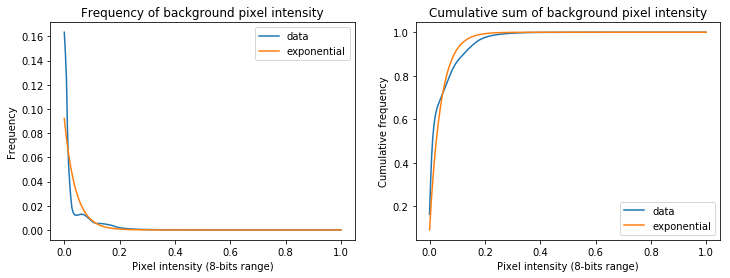

In [19]:
xx = np.arange(256) / 255
p_offset = 1E-6

print("E(X) =", np.sum(p_bkg * xx))
print("STD(X) =", np.sqrt(np.sum(p_bkg * (xx - np.sum(p_bkg * xx)) ** 2)))

# Exponential distribution
lambda_hat = 1 / np.sum(p_bkg * xx)
p_exp = lambda_hat * np.exp(- lambda_hat * xx)
p_exp += p_offset
print("LL_exp =", np.sum(p_bkg * np.log(p_exp)))
p_exp /= p_exp.sum()
print("KL_exp =", entropy(p_bkg, p_exp))

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(xx, p_bkg)
plt.plot(xx, p_exp)
plt.title("Frequency of background pixel intensity")
plt.xlabel("Pixel intensity (8-bits range)")
plt.ylabel("Frequency")
plt.legend(["data", "exponential"])
plt.subplot(122)
plt.plot(xx, np.cumsum(p_bkg))
plt.plot(xx, np.cumsum(p_exp))
plt.title("Cumulative sum of background pixel intensity")
plt.xlabel("Pixel intensity (8-bits range)")
plt.ylabel("Cumulative frequency")
plt.legend(["data", "exponential"])
plt.show()

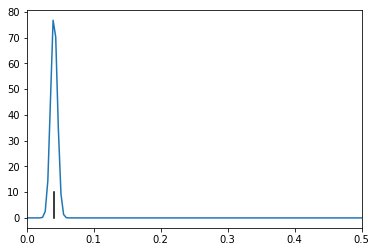

In [20]:
# Add variability to background intensity (some deviation of the mean)
plt.plot(np.arange(256)/255, 
         norm.pdf(np.arange(256)/255, 
                  loc=np.sum(p_bkg * np.arange(256) / 255), scale=0.005))
plt.plot([np.sum(p_bkg * np.arange(256) / 255), np.sum(p_bkg * np.arange(256) / 255)],
         [0, 10], 'k')
plt.xlim(0,0.5)
plt.show()

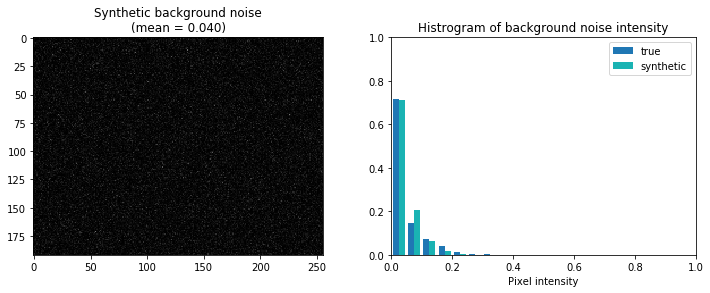

In [24]:
bkg = np.zeros(shape, dtype=np.float32)

noise_mean = np.random.normal(loc=np.sum(p_bkg * np.arange(256) / 255), scale=0.005)
noise = np.random.exponential(scale=noise_mean, size=shape)

noise_hist = plt.hist(noise.ravel(), align="mid", bins=new_bins, weights=np.ones(noise.size) / noise.size)[0]
plt.close()

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(bkg + noise, vmin=0, vmax=1, cmap='gray')
plt.title("Synthetic background noise\n(mean = %.3f)" % noise_mean)
plt.subplot(122)
plt.bar(new_bins[:-1] + offset_left, new_pixel_bkg / new_pixel_bkg.sum(), width=width)
plt.bar(new_bins[:-1] + offset_right, noise_hist, width=width, color=[0.1, 0.7, 0.7])
plt.xlim(0, 1); plt.ylim(0, 1)
plt.title("Histrogram of background noise intensity")
plt.xlabel("Pixel intensity")
plt.legend(["true", "synthetic"])
plt.show()

# All together 

Mix background, warped neurons and background noise together. Using simple addition might causes the neurons to be too bright, so we use max().

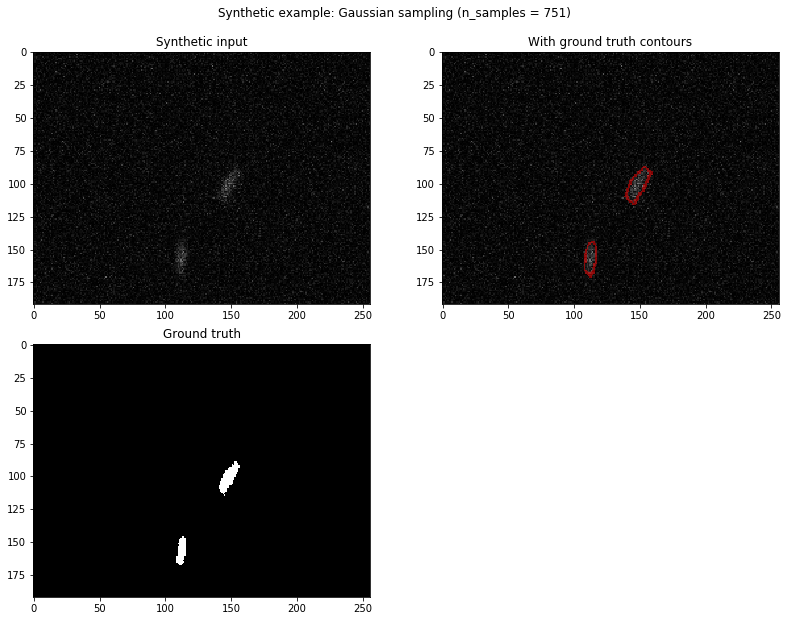

In [25]:
img_display = np.stack([bkg, wrp_neurons_weight, noise], axis=0).max(axis=0)

plt.figure(figsize=(11.5,9))
plt.suptitle("Synthetic example: Gaussian sampling (n_samples = %d)" % n_samples)
plt.subplot(221)
plt.title("Synthetic input")
plt.imshow(img_display, vmin=0, vmax=1, cmap='gray')
plt.subplot(222)
plt.title("With ground truth contours")
plt.imshow(overlay_mask(img_display, 
                        wrp_contours.sum(0), opacity=0.5, mask_color=[1,0,0]))
plt.subplot(223)
plt.title("Ground truth")
plt.imshow(wrp_segs, cmap='gray')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Adjust intensity and saturation
Add some random saturation, gamma correction, etc. to simulate different laser gain and noise intensities.

gamma = 0.70341441331069


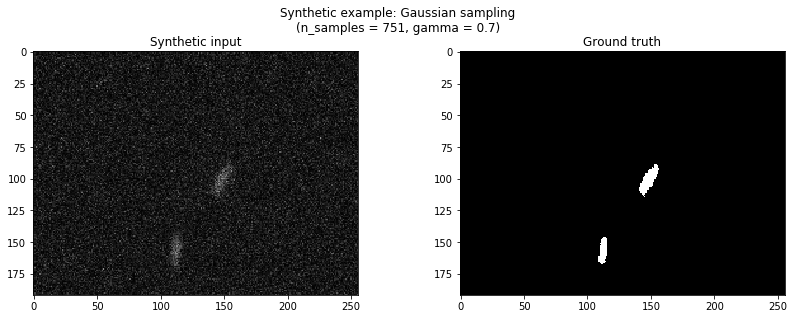

In [26]:
# Test random gamma correction
gamma = np.random.rand() * 0.6 + 0.7
print("gamma =", gamma)

img_display = exposure.adjust_gamma(
    np.stack([bkg, wrp_neurons_weight, noise], axis=0).max(axis=0), gamma=gamma)

plt.figure(figsize=(12,4.5))
plt.suptitle("Synthetic example: Gaussian sampling\n(n_samples = %d, gamma = %.1f)" % (n_samples, gamma))
plt.subplot(121)
plt.title("Synthetic input")
plt.imshow(img_display, cmap='gray', vmin=0, vmax=1)
plt.subplot(122)
plt.title("Ground truth")
plt.imshow(wrp_segs, cmap='gray')
plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.show()